In [360]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
USE_BED = True
LOAD_FULL_FILE = True

In [4]:
# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

### FUNCTIONS

In [137]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [138]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [139]:
def calculateMBAFCountBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].count()

In [140]:
def calculateMBAFBetween(chrom,minPos,maxPos):
   return dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]['mBAF'].median()

In [141]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [142]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [143]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [144]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [145]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

In [146]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("CPCT02")
    return filename[patientIDStart:patientIDStart+12]

In [147]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [148]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [149]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,5])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [150]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

### LOAD PON

In [ ]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [313]:
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02050117/"

In [314]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
cnvFilename = findFiles(PATH,"gz_CNVs")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170303_HMFregCPCT_FR13274325_FR13274449_CPCT02050117.annotatedSLICED.vcf
somatic = CPCT02050117R_CPCT02050117T_melted.vcf
patient = CPCT02050117
CNV = CPCT02050117T_dedup.realigned.pileup.gz_CNVs


### LOAD VCFS

In [315]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170303_HMFregCPCT_FR13274325_FR13274449_CPCT02050117.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 343053
reading vcf file: CPCT02050117R_CPCT02050117T_melted.vcf
reading VCF File line: 1
Number variants loaded: 42721


In [316]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [317]:
dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
dfBAF.columns = ['Chromosome', 'Position','BAF']
dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
dfBAF.head(1)

,Chromosome,Position,BAF,mBAF,chromPos
138,1,4120556,0.405797,0.594203,1.016532


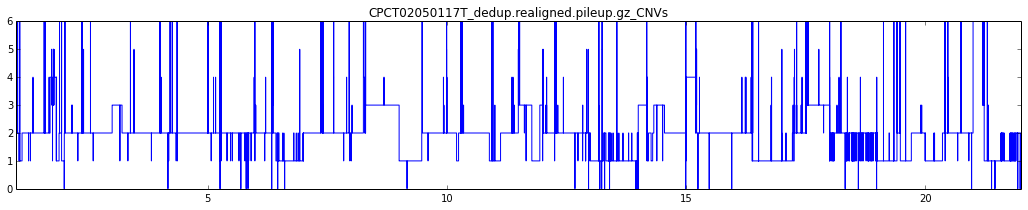

In [318]:
dfCNV = loadCNVforPatient(PATH+cnvFilename,patientID)
dfCNV['mBAF'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
dfCNV['mBAFCount'] = np.vectorize(calculateMBAFCountBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
cnvChart(dfCNV,cnvFilename,1,22)

### TUMOR PURITY

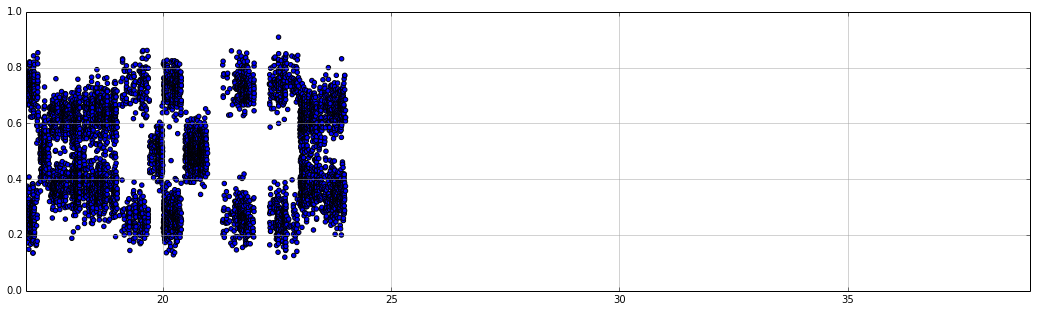

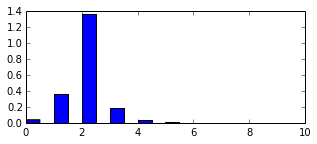

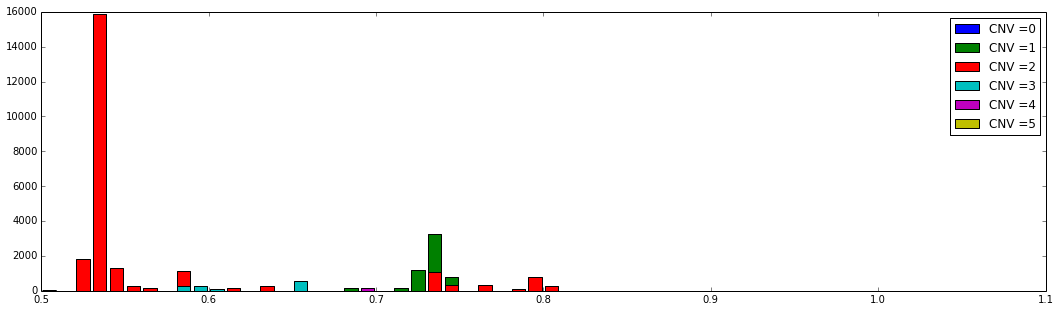

In [442]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>100)&(dfCNV.chromPos<=c+fractionMax)&(dfCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [446]:
dfCNV[(dfCNV.copyNum>0)&(dfCNV.mBAF<1.54)&(dfCNV.mBAF>0.75)\
      &(dfCNV.mBAFCount>100)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
338,8,18654000,2,8.127449,14727000,0.760000,341
931,15,25534000,2,15.249036,3003000,0.783019,104
935,15,28970000,2,15.282548,9007000,0.794977,166
936,15,37977000,2,15.370394,10261000,0.790000,125
948,15,57688000,2,15.562637,5414000,0.795786,218
954,15,66168000,2,15.645344,10242000,0.803922,149
958,15,77882000,2,15.759592,5360000,0.803960,116
959,15,83242000,2,15.811868,4666000,0.793611,102
961,15,88401000,2,15.862185,6375000,0.797848,194


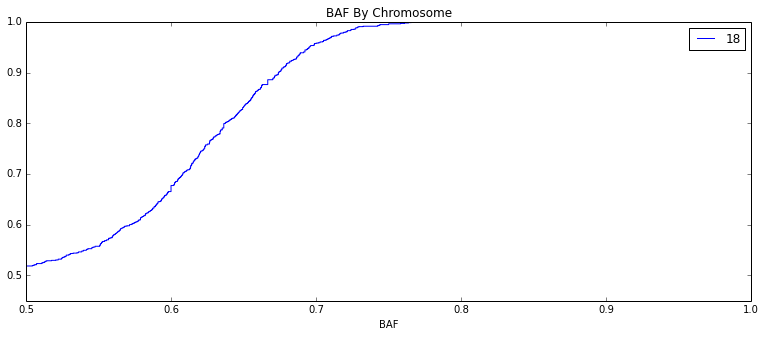

In [411]:
chromosomes = [18]#dfBAF['Chromosome'].unique()
for chromosome in chromosomes:
    ser = dfBAF[dfBAF.Chromosome==chromosome]["BAF"]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
    ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,5],xlim=[0.5,01.0],ylim=[0.45,1.0])

In [322]:
dfCNV[(dfCNV.chrom==21)&(dfCNV.mBAFCount>200)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount


### SOMATIC AF

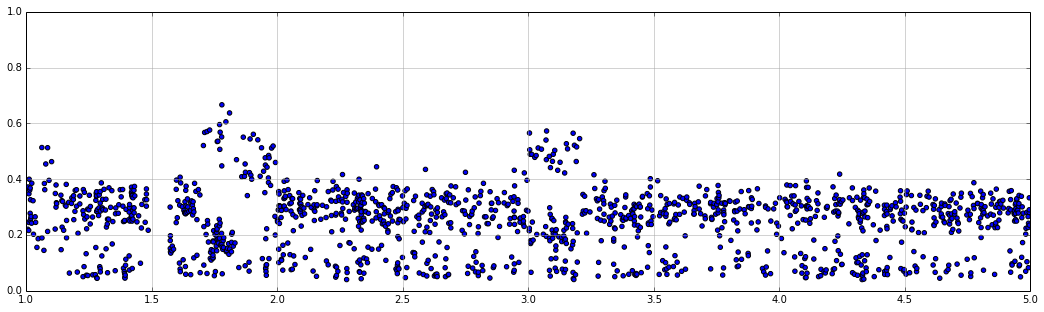

In [448]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

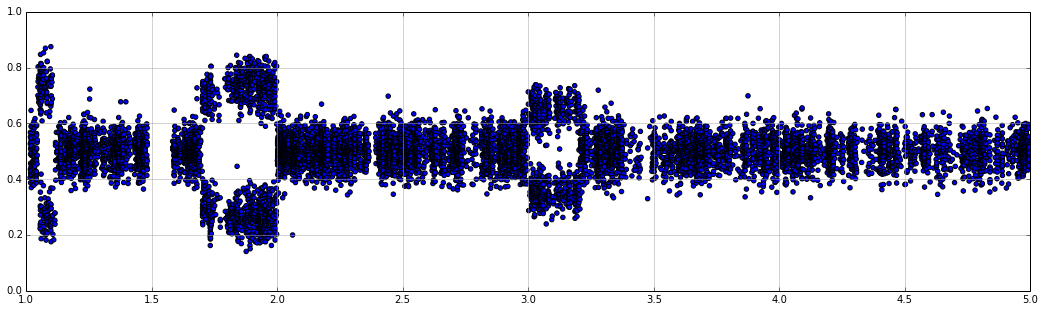

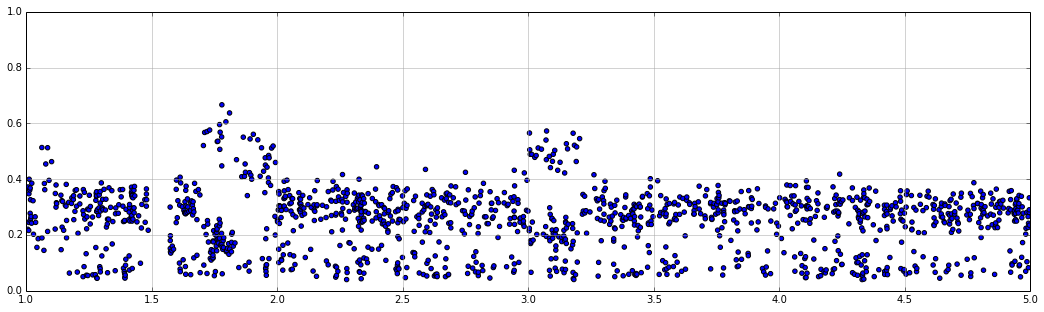

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
2,1,826000,2,1.003314,4900999,0.552846,37
4,1,5736000,2,1.023013,6011999,0.549851,58
5,1,11748000,1,1.047133,5102000,0.744444,85
10,1,17276000,1,1.069312,11681000,0.736842,123
11,1,28957000,2,1.116176,33963999,0.532787,501
13,1,63424000,2,1.254459,9330999,0.525000,93
15,1,72812000,2,1.292124,13167999,0.533981,97
17,1,86005000,2,1.345054,58858999,0.533333,489
22,1,145118000,2,1.582217,2589999,0.526551,32
28,1,149240000,2,1.598755,20482999,0.527516,324


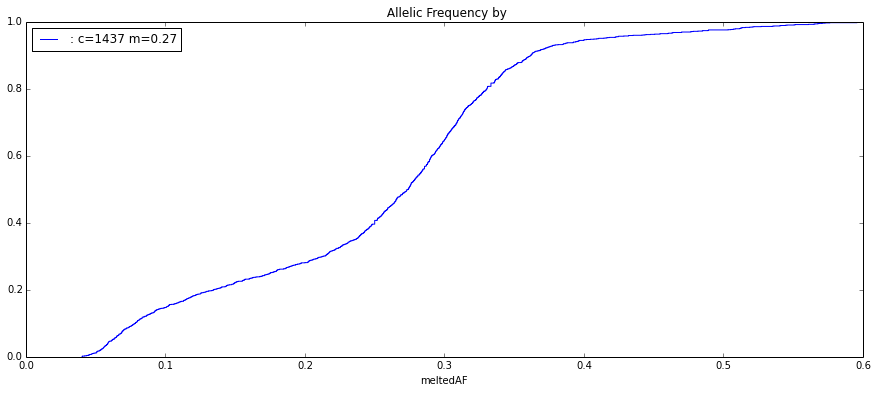

In [451]:
c,fractionMin,fractionMax = 1,0,4
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.6])

#mbaf
dfCNV[(dfCNV.chromPos>c+fractionMin)&(dfCNV.chromPos<c+fractionMax)&(dfCNV.mBAFCount>20)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

In [401]:
dfSomatic.head(4)

,chrom,pos,chromPos,chromFrac,id,ref,vennSegment,numCallers,variantType,variantSubType,filter,bedRegion,inDBSNP,inCOSMIC,annGene,annWorstImpact,annWorstEffect,annAllEffects,consensus,meltedallele,meltedAF,meltedDP,meltedQS,meltedSGT,meltedindelDiff,meltedSVLenMin,meltedSVLenMax,meltedSVStartMin,meltedSVStartMax,patientName,alt,PONCount,inPON
0,1,17746,1:17746,1.000071,.,A,freebayes-varscan,2,SNP,,PASS,,False,False,WASH7P,LOW,splice_region_variant&intron_variant,splice_region_variant&intron_variant|splice_re...,False,G,0.241379,119,-1.0,0/1,,,,,,CPCT02050117,G,683,True
1,1,53745,1:53745,1.000216,.,T,freebayes,1,SNP,,.,,False,False,OR4G4P,MODIFIER,intron_variant,intron_variant,False,C,0.238806,67,-1.0,0/1,,,,,,CPCT02050117,C,527,True
2,1,57246,1:57246,1.000230,.,C,mutect,1,SNP,,PASS,,False,False,,,,,False,G,0.052632,114,-1.0,0/1,,,,,,CPCT02050117,G,183,True
3,1,57856,1:57856,1.000232,rs199609147,T,freebayes,1,SNP,,.,,True,False,,,,,False,A,0.395161,125,-1.0,0/1,,,,,,CPCT02050117,A,650,True


TypeError: Empty 'DataFrame': no numeric data to plot

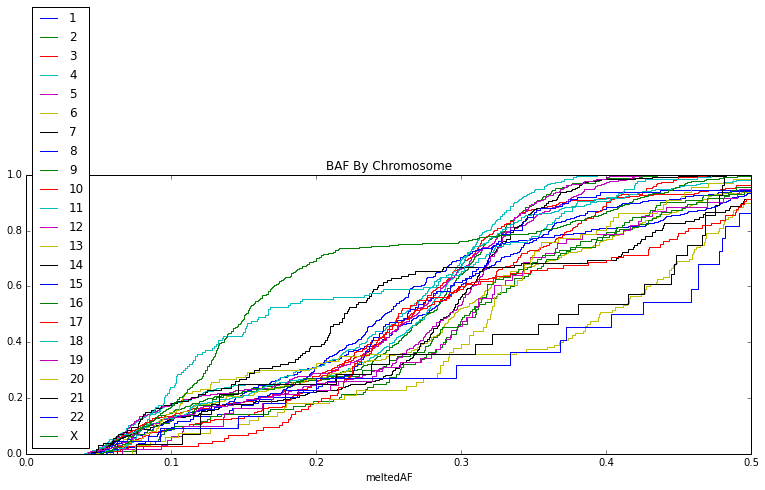

In [404]:
chromosomes = dfSomatic['chrom'].unique()
for chromosome in chromosomes:
    ser = dfSomatic[(dfSomatic.chrom==chromosome)&(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)]["meltedAF"]
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
    ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,5],xlim=[0.0,0.5],ylim=[0.0,1.0])

In [406]:
len(dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)])

4846

In [407]:
len(dfSomatic)

42721